# Practice Session : Machine Learning over Spark

In this notebook, we practice what you learned during the SparkML lecture.

<img src="https://content.altexsoft.com/media/2020/05/word-image-43.png" width="600px">

## Introduction

### Lab Goals


* Get familiar with SparkML (MLlib is Apache Spark's scalable machine learning library) and understand the main concepts of Pipelines
* Takes you through building a simple logistic regression model using Spark's ML pipeline interface and tunning model hyperparameters.
* Gain knowledge how to apply unsupervised learning(Kmeans, PCA) with SparkML.

### Machine Learning Library (MLlib)
MLlib standardizes APIs for machine learning algorithms to make it easier to combine multiple algorithms into a single pipeline, or workflow. This section covers the key concepts introduced by the Pipelines API, where the pipeline concept is mostly inspired by the scikit-learn project.



   * **DataFrame**: This ML API uses DataFrame from Spark SQL as an ML dataset, which can hold a variety of data types. E.g., a DataFrame could have different columns storing text, feature vectors, true labels, and predictions.

   * **Transformer**: A Transformer is an algorithm which can transform one DataFrame into another DataFrame. A feature transformer might take a DataFrame, read a column (e.g., text), map it into a new column (e.g., feature vectors), and output a new DataFrame with the mapped column appended. Also, a learning model might take a DataFrame, read the column containing feature vectors, predict the label for each feature vector, and output a new DataFrame with predicted labels appended as a column.
   * **Estimator**: An Estimator is an algorithm which can be fit on a DataFrame to produce a Transformer. Technically, an Estimator implements a method ```fit()```, which accepts a DataFrame and produces a Model, which is a Transformer. For example, a learning algorithm such as LogisticRegression is an Estimator, and calling ```fit()``` trains a *LogisticRegressionModel*, which is a Model and hence a *Transformer*.

   * **Pipeline**: A Pipeline chains multiple Transformers and Estimators together to specify an ML workflow.

   * **Parameter**: All Transformers and Estimators now share a common API for specifying parameters.



## Part 1
Building a logistic regression model using Spark's ML pipeline interface.

### Data Ingestion:
We are going to use Adult dataset https://archive.ics.uci.edu/ml/datasets/Adult. This data derives from census data, and consists of information about individuals and their annual income. We will use this information to predict if an individual earns <=50K or >50k a year.


* **Configure your SparkContext. You can set the master, by default this will use a local master unless you add setMaster or change your enviorment variables.**

* **Use get or create here so that if the cell is evaluated multiple times we don't get multiple SparkContexts.**
    

In [1]:
# SparkContext represents the connection to a Spark cluster
from pyspark.context import SparkContext
# Configuration for a Spark application
from pyspark.conf import SparkConf
# The entry point to programming Spark with the Dataset and DataFrame API
from pyspark.sql.session import SparkSession
from pyspark.sql.functions import col

conf = SparkConf().setAppName("practice_session_SparkML")
sc = SparkContext.getOrCreate()
spark = SparkSession.builder.getOrCreate()

spark.conf.set("spark.sql.repl.eagerEval.enabled",True) # OK for exploration, not great for performance
spark.conf.set("spark.sql.repl.eagerEval.truncate", 500)

### Exploratory Data Analysis (EDA)
Let's try some simple operations with PySpark and get familiar with the data!

**The data came as a zip, so let`s manipulate it to be able to use in the notebook**

In [2]:
!unzip -u adult.zip 

Archive:  adult.zip


**Now start by loading some data which is in csv format**

In [3]:
df = spark.read.format("csv").option("header", "true").load("./adult.data")

**Have a look on the dataframe and write down the attributes and their types**

In [4]:
df.printSchema()

root
 |-- age: string (nullable = true)
 |-- workclass: string (nullable = true)
 |-- fnlwgt: string (nullable = true)
 |-- education: string (nullable = true)
 |-- education_num: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- capital_gain: string (nullable = true)
 |-- capital_loss: string (nullable = true)
 |-- hours_per_week: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- category: string (nullable = true)



**Display a subset of the dataframe**

In [5]:
df.show(5)

+---+-----------------+-------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+--------+
|age|        workclass| fnlwgt| education|education_num|     marital_status|        occupation|  relationship|  race|    sex|capital_gain|capital_loss|hours_per_week|native_country|category|
+---+-----------------+-------+----------+-------------+-------------------+------------------+--------------+------+-------+------------+------------+--------------+--------------+--------+
| 39|        State-gov|  77516| Bachelors|           13|      Never-married|      Adm-clerical| Not-in-family| White|   Male|        2174|           0|            40| United-States|   <=50K|
| 50| Self_emp-not-inc|  83311| Bachelors|           13| Married-civ-spouse|   Exec-managerial|       Husband| White|   Male|           0|           0|            13| United-States|   <=50K|
| 38|          Private| 215646|   HS-grad|   

In [6]:
df.show(n=1, truncate=False, vertical=True)

-RECORD 0------------------------
 age            | 39             
 workclass      |  State-gov     
 fnlwgt         |  77516         
 education      |  Bachelors     
 education_num  |  13            
 marital_status |  Never-married 
 occupation     |  Adm-clerical  
 relationship   |  Not-in-family 
 race           |  White         
 sex            |  Male          
 capital_gain   |  2174          
 capital_loss   |  0             
 hours_per_week |  40            
 native_country |  United-States 
 category       |  <=50K         
only showing top 1 row



In [7]:
type(df)

pyspark.sql.dataframe.DataFrame

In [8]:
#Spark dataframes can be interoperable with pandas too
df.limit(10).toPandas()

,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,category
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self_emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
5,37,Private,284582,Masters,14,Married-civ-spouse,Exec-managerial,Wife,White,Female,0,0,40,United-States,<=50K
6,49,Private,160187,9th,5,Married-spouse-absent,Other-service,Not-in-family,Black,Female,0,0,16,Jamaica,<=50K
7,52,Self-emp-not-inc,209642,HS-grad,9,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,45,United-States,>50K
8,31,Private,45781,Masters,14,Never-married,Prof-specialty,Not-in-family,White,Female,14084,0,50,United-States,>50K
9,42,Private,159449,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,5178,0,40,United-States,>50K


**So far Spark has simply loaded all of the values as strings since we haven't specified another schema. We need to specify it or let spark infer the schema**

In [9]:
adult_schema = "age integer, workclass string, fnlwgt double, education string, education_num double, marital_status string, occupation string, relationship string, race string, sex string, capital_gain double, capital_loss double, hours_per_week float, native_country string, category string"

In [10]:
#df = spark.read.format("csv").option("header", "true").option("inferSchema", "true").load("./adult.data") # Let spark infer the schema ( schema also handle this extra space)
df = df.select(col("age").cast("integer"), 
               col("fnlwgt").cast("double"), 
               col("education_num").cast("double"), 
               col("capital_gain").cast("double"),
               col("capital_loss").cast("double"),
               col("hours_per_week").cast("double"),
               col("workclass"),
               col("education"),
               col("marital_status"),
               col("occupation"),
               col("relationship"),
               col("race"),
               col("sex"),
               col("native_country"),
               col("category"))
#df = spark.read.format("csv").option("header", "true").schema(adult_schema).load("./adult.data") #Provide a schema (faster for large data)

**Have a look on the dataframe and write down the attributes and their types (Cache the dataframe in memory)**

In [11]:
df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education_num: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- education: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- category: string (nullable = true)



**Get a summary statistics, of the data, you can use describe(). It will compute the count, mean, standard deviation, min, max**

In [12]:
df.describe().toPandas()

,summary,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week,workclass,education,marital_status,occupation,relationship,race,sex,native_country,category
0,count,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561,32561
1,mean,38.58164675532078,189778.36651208502,10.0806793403151,1077.6488437087312,87.303829734959,40.437455852092995,None,None,None,None,None,None,None,None,None
2,stddev,13.640432553581356,105549.97769702227,2.572720332067397,7385.292084840354,402.960218649002,12.347428681731838,None,None,None,None,None,None,None,None,None
3,min,17,12285.0,1.0,0.0,0.0,1.0,?,10th,Divorced,?,Husband,Amer-Indian-Eskimo,Female,?,<=50K
4,max,90,1484705.0,16.0,99999.0,4356.0,99.0,Without-pay,Some-college,Widowed,Transport-moving,Wife,White,Male,Yugoslavia,>50K


**Notice how many of our variables are categorical. The description isn't very helpful for them. Let's focus on the numeric columns only**

In [13]:
#Looking only at numeric variables
df.describe("age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week").toPandas() #Leveraging the describe function
#df[["age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week"]].describe().toPandas() #Pandas-like syntax
#df.select("age", "fnlwgt", "education_num", "capital_gain", "capital_loss", "hours_per_week").describe().toPandas() #SQL like syntax

,summary,age,fnlwgt,education_num,capital_gain,capital_loss,hours_per_week
0,count,32561,32561,32561,32561,32561,32561
1,mean,38.58164675532078,189778.36651208502,10.0806793403151,1077.6488437087312,87.303829734959,40.437455852092995
2,stddev,13.640432553581356,105549.97769702227,2.572720332067397,7385.292084840354,402.960218649002,12.347428681731838
3,min,17,12285.0,1.0,0.0,0.0,1.0
4,max,90,1484705.0,16.0,99999.0,4356.0,99.0


**We can use the function distinct to evaluate how many categories there are. Also, we can use groupby to see the counts by category**

In [14]:
#df.select("race").distinct()
df.groupby("race").count()

race,count
Asian-Pac-Islander,1039
Black,3124
Other,271
White,27816
Amer-Indian-Eskimo,311


**In some occasion, it can be interesting to see the descriptive statistics between two pairwise columns. Count the number of people with income below or above 50k by education level. This operation is called a crosstab.**

In [15]:
df.crosstab('age', 'category').sort("age_category").show(100)

+------------+------+-----+
|age_category| <=50K| >50K|
+------------+------+-----+
|          17|   395|    0|
|          18|   550|    0|
|          19|   710|    2|
|          20|   753|    0|
|          21|   717|    3|
|          22|   752|   13|
|          23|   865|   12|
|          24|   767|   31|
|          25|   788|   53|
|          26|   722|   63|
|          27|   754|   81|
|          28|   748|  119|
|          29|   679|  134|
|          30|   690|  171|
|          31|   705|  183|
|          32|   639|  189|
|          33|   684|  191|
|          34|   643|  243|
|          35|   659|  217|
|          36|   635|  263|
|          37|   566|  292|
|          38|   545|  282|
|          39|   538|  278|
|          40|   526|  268|
|          41|   529|  279|
|          42|   510|  270|
|          43|   497|  273|
|          44|   443|  281|
|          45|   446|  288|
|          46|   445|  292|
|          47|   420|  288|
|          48|   326|  217|
|          49|   371

**Use drop() API to drop education_num column**

In [16]:
df.drop('education-num').columns

['age',
 'fnlwgt',
 'education_num',
 'capital_gain',
 'capital_loss',
 'hours_per_week',
 'workclass',
 'education',
 'marital_status',
 'occupation',
 'relationship',
 'race',
 'sex',
 'native_country',
 'category']

### Data preparation (or data preprocessing)

<p align="center">
<img src="https://content.altexsoft.com/media/2020/05/word-image-43.png" width="600px">
</p>

Data processing is a critical step in machine learning. For instance, you know that age is not a linear function with the income. When people are young, their income is usually lower than mid-age. After retirement, a household uses their saving, meaning a decrease in income. To capture this pattern, you can apply a quadratic function to the age feature, creating a new feature. 

<p align="center">
<img src="https://richbeveridge.files.wordpress.com/2009/10/general-parabola.jpg" width="600px">
</p>

Such graphed equation can be defined as an inverse parabola with the formula: $-0.05x² + 5.5x - 55$. This equation is arbritary, but can act as a feature based on the age and income understanding.

To add a new feature, you need to:  

* **Select the column**
* **Apply the transformation and add it to the DataFrame**

**After applying the transformation, print the schema**

In [17]:
from pyspark.sql.functions import *

#  Apply the transformation and add it to the DataFrame
df = df.withColumn("age_square", -0.05*col("age")**2 + 5.5*col("age")-55)

df.printSchema()

root
 |-- age: integer (nullable = true)
 |-- fnlwgt: double (nullable = true)
 |-- education_num: double (nullable = true)
 |-- capital_gain: double (nullable = true)
 |-- capital_loss: double (nullable = true)
 |-- hours_per_week: double (nullable = true)
 |-- workclass: string (nullable = true)
 |-- education: string (nullable = true)
 |-- marital_status: string (nullable = true)
 |-- occupation: string (nullable = true)
 |-- relationship: string (nullable = true)
 |-- race: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- native_country: string (nullable = true)
 |-- category: string (nullable = true)
 |-- age_square: double (nullable = true)



**You can see that age_square has been successfully added to the data frame. Now change the order of the variables with select; bring age_square right after age and then print the first record.**

In [18]:
COLUMNS = ['age', 'age_square', 'workclass', 'fnlwgt', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'capital_gain', 'capital_loss', 'hours_per_week', 'native_country', 'category']
df = df.select(COLUMNS)
df.show(2)

+---+-----------------+-----------------+-------+----------+-------------------+----------------+--------------+------+-----+------------+------------+--------------+--------------+--------+
|age|       age_square|        workclass| fnlwgt| education|     marital_status|      occupation|  relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|category|
+---+-----------------+-----------------+-------+----------+-------------------+----------------+--------------+------+-----+------------+------------+--------------+--------------+--------+
| 39|83.44999999999999|        State-gov|77516.0| Bachelors|      Never-married|    Adm-clerical| Not-in-family| White| Male|      2174.0|         0.0|          40.0| United-States|   <=50K|
| 50|             95.0| Self_emp-not-inc|83311.0| Bachelors| Married-civ-spouse| Exec-managerial|       Husband| White| Male|         0.0|         0.0|          13.0| United-States|   <=50K|
+---+-----------------+-----------------+----

Spark has two different machine learning libraries, SparkML DataFrame-based is the default one and the SparkML RDD-based has entered maintenance mode. We will use the default one which is defined in pyspark.ml.

#### On pipelining with Spark

Similar to scikit-learn, Pyspark has a pipeline API. A pipeline is very convenient to maintain the structure of the data. You push the data into the pipeline. Inside the pipeline, various operations are done, the output is used to feed the algorithm.

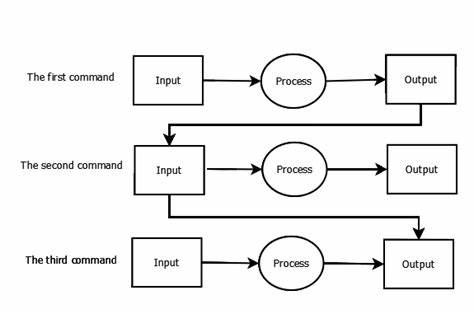


**Since we are going to try Logistic Regression algorithm, we will have to convert the categorical variables in the dataset into numeric variables. There are 2 ways we can do this.**
  *  **Category Indexing:** this is basically assigning a numeric value to each category from {0, 1, 2, ...numCategories-1}. This introduces an implicit ordering among your categories, and is more suitable for ordinal variables (eg: Poor: 0, Average: 1, Good: 2)
  * **One-Hot Encoding:** this converts categories into binary vectors with at most one nonzero value (eg: (Blue: [1, 0]), (Green: [0, 1]), (Red: [0, 0]))

Here, we will use a combination of StringIndexer and OneHotEncoderEstimator to convert the categorical variables.
   
Since we will have more than 1 stage of feature transformations, we use a Pipeline to tie the stages together. This simplifies our code.

**1. Index each categorical column using the StringIndexer, and then converts the indexed categories into one-hot encoded variables. The resulting output has the binary vectors appended to the end of each row.**

In [19]:
from pyspark.mllib.linalg import Vectors
from pyspark.ml.param import Param, Params
from pyspark.ml.feature import OneHotEncoder, VectorAssembler, StringIndexer, Normalizer
from pyspark.ml import Pipeline

In [20]:
from pyspark.ml import Pipeline
from pyspark.ml.feature import OneHotEncoder
CATE_FEATURES = ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
stages = [] # stages in our Pipeline
for categoricalCol in CATE_FEATURES:
    stringIndexer = StringIndexer(inputCol=categoricalCol, outputCol=categoricalCol + "Index")
    encoder = OneHotEncoder(inputCols=[stringIndexer.getOutputCol()], outputCols=[categoricalCol + "classVec"])
    stages += [stringIndexer, encoder]

**2. Index the class label (category)**

Spark, like many other libraries, does not accept string values for the label. You convert the label feature with StringIndexer and add it to the list stages

In [21]:
df.show(2)

+---+-----------------+-----------------+-------+----------+-------------------+----------------+--------------+------+-----+------------+------------+--------------+--------------+--------+
|age|       age_square|        workclass| fnlwgt| education|     marital_status|      occupation|  relationship|  race|  sex|capital_gain|capital_loss|hours_per_week|native_country|category|
+---+-----------------+-----------------+-------+----------+-------------------+----------------+--------------+------+-----+------------+------------+--------------+--------------+--------+
| 39|83.44999999999999|        State-gov|77516.0| Bachelors|      Never-married|    Adm-clerical| Not-in-family| White| Male|      2174.0|         0.0|          40.0| United-States|   <=50K|
| 50|             95.0| Self_emp-not-inc|83311.0| Bachelors| Married-civ-spouse| Exec-managerial|       Husband| White| Male|         0.0|         0.0|          13.0| United-States|   <=50K|
+---+-----------------+-----------------+----

In [22]:
# Convert label into label indices using the StringIndexer
label_stringIdx =  StringIndexer(inputCol="category", outputCol="label")
stages += [label_stringIdx]

**3. Use a VectorAssembler to combine all the feature columns into a single vector column. This includes both the numeric columns and the one-hot encoded binary vector columns in our dataset.**


In [23]:
# Transform all features into a vector using VectorAssembler
numericCols = ["age", "age_square", "fnlwgt", "capital_gain", "capital_loss", "hours_per_week"]
assemblerInputs = [c + "classVec" for c in CATE_FEATURES] + numericCols
assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")
stages += [assembler]

**4. Now that all the steps are ready, push the data to the pipeline.**

In [24]:
# Create a Pipeline.
pipeline = Pipeline().setStages(stages)
pipelineModel = pipeline.fit(df)
PreparedData = pipelineModel.transform(df)

In [25]:
#PreparedData.show(1)
PreparedData.show(n=1, truncate=False, vertical=True)

-RECORD 0---------------------------------------------------------------------------------------------------------------------------------------------
 age                    | 39                                                                                                                          
 age_square             | 83.44999999999999                                                                                                           
 workclass              |  State-gov                                                                                                                  
 fnlwgt                 | 77516.0                                                                                                                     
 education              |  Bachelors                                                                                                                  
 marital_status         |  Never-married                                                      

**Randomly split data into training and test sets. Set seed for reproducibility**

In [26]:
(trainingData, testData) = PreparedData.randomSplit([0.7, 0.3], seed=100)
print(trainingData.count())
print(testData.count())

22832
9729


#### Model training


<p align="center">
<img src="https://content.altexsoft.com/media/2020/05/word-image-43.png" width="600px">
</p>

**Create initial LogisticRegression model and set the regularization parameter =0.1**

In [27]:
from pyspark.ml.classification import LogisticRegression

lr = LogisticRegression(labelCol="label", featuresCol="features", maxIter=10, regParam=0.1)


In [28]:
# Train model with Training Data
lrModel = lr.fit(trainingData)

In [29]:
# Make predictions on test data using the transform() method.
# LogisticRegression.transform() will only use the 'features' column.
predictions = lrModel.transform(testData)

In [30]:
# View model's predictions and probabilities of each prediction class
# You can select any columns in the above schema to view as well. For example's sake we will choose age & occupation
selected = predictions.select("label", "prediction", "probability", "age")
display(selected.show(5))


+-----+----------+--------------------+---+
|label|prediction|         probability|age|
+-----+----------+--------------------+---+
|  0.0|       0.0|[0.99000361616974...| 17|
|  0.0|       0.0|[0.98483072032363...| 17|
|  0.0|       0.0|[0.98664466872099...| 17|
|  0.0|       0.0|[0.98236185047222...| 17|
|  0.0|       0.0|[0.9847505913893,...| 17|
+-----+----------+--------------------+---+
only showing top 5 rows



None

**We can use BinaryClassificationEvaluator to evaluate our model. We can set the required column names in rawPredictionCol and labelCol Param and the metric in metricName Param.**

**Note that the default metric for the BinaryClassificationEvaluator is areaUnderROC**

In [31]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Evaluate model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction")
evaluator.evaluate(predictions)

0.8999565338720047

### Model Hyperparameter Tuning

In machine learning problems, it is necessary to distinguish the model's parameters and hyperparameters (structural parameters). The model parameters are adjusted during the training process (e.g., weights in the linear model or the decision tree structure). On the other hand, hyperparameters are set in advance (for example, the regularization in linear model or maximum depth of the decision tree). Each model usually has many hyperparameters, and there is no universal set of optimal hyperparameters that work in all tasks. For each task, one should choose a different set of hyperparameters. Grid search is commonly used to optimize model hyperparameters. For each hyperparameter, several values are evaluated. The combination of parameter values where the model shows the best quality (in terms of the metric that is being optimized) is selected. However, in this case, it is necessary to correctly assess the constructed model, namely to do the split into training and testing samples.

**Now try the model with the ParamGridBuilder and the CrossValidator.**

**If you are unsure what params are available for tuning, you can use explainParams() to print a list of all params and their definitions.**


In [32]:
print(lr.explainParams())

aggregationDepth: suggested depth for treeAggregate (>= 2). (default: 2)
elasticNetParam: the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty. (default: 0.0)
family: The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial (default: auto)
featuresCol: features column name. (default: features, current: features)
fitIntercept: whether to fit an intercept term. (default: True)
labelCol: label column name. (default: label, current: label)
lowerBoundsOnCoefficients: The lower bounds on coefficients if fitting under bound constrained optimization. The bound matrix must be compatible with the shape (1, number of features) for binomial regression, or (number of classes, number of features) for multinomial regression. (undefined)
lowerBoundsOnIntercepts: The lower bounds on intercepts if fitting under bound constrained optimization. The

**As we indicate 3 values for regParam, 3 values for maxIter, and 3 values for elasticNetParam, this grid will have 3 x 3 x 3 = 27 parameter settings for CrossValidator to choose from. We will create a 5-fold cross validator.**

In [33]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Create ParamGrid for Cross Validation
paramGrid = (ParamGridBuilder()
             .addGrid(lr.regParam, [0.01, 0.5, 2.0])
             .addGrid(lr.elasticNetParam, [0.0, 0.5, 1.0])
             .addGrid(lr.maxIter, [1, 5, 10])
             .build())


In [34]:
# Create 5-fold CrossValidator
cv = CrossValidator(estimator=lr, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations
cvModel = cv.fit(trainingData)
# this will likely take a fair amount of time because of the amount of models that we're creating and testing

In [35]:
# Use test set to measure the accuracy of our model on new data
predictions = cvModel.transform(testData)

In [36]:
# cvModel uses the best model found from the Cross Validation
# Evaluate best model
evaluator.evaluate(predictions)

0.909934479262013

By using SparkML, we managed to get a regressor that has an $R²$ value of nearly $0.9$. From this, you can experiment with other models, other tasks (Classification, Clustering) and try to implement your ML models

## Part 2
In the second part of our practice session, we'll talk about unsupervised learning methods like Kmeans and PCA! As a result, we will build a kmeans model here.

### Dataset
<b>Dataset location: </b>https://www.kaggle.com/c/titanic/data?select=train.csv

In [37]:
!unzip -u titanic.zip

Archive:  titanic.zip


In [38]:
from pyspark.sql import SparkSession

spark = SparkSession \
    .builder \
    .appName('Examine data about passengers on the Titanic') \
    .getOrCreate()

rawData = spark.read\
            .format('csv')\
            .option('header', 'true')\
            .load('./train.csv')

### EDA
Let us get familiar with the data.

In [39]:
rawData.toPandas().head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.25,None,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.925,None,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.05,None,S


Select the columns which we required Also cast the numeric values as float

In [40]:
rawData.printSchema()

root
 |-- PassengerId: string (nullable = true)
 |-- Survived: string (nullable = true)
 |-- Pclass: string (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: string (nullable = true)
 |-- SibSp: string (nullable = true)
 |-- Parch: string (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: string (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)



In [41]:
from pyspark.sql.functions import col

dataset = rawData.select(col('Survived').cast('float'),
                         col('Pclass').cast('float'),
                         col('Sex'),
                         col('Age').cast('float'),
                         col('Fare').cast('float'),
                         col('Embarked')
                        )

dataset.toPandas().head()

,Survived,Pclass,Sex,Age,Fare,Embarked
0,0.0,3.0,male,22.0,7.250000,S
1,1.0,1.0,female,38.0,71.283302,C
2,1.0,3.0,female,26.0,7.925000,S
3,1.0,1.0,female,35.0,53.099998,S
4,0.0,3.0,male,35.0,8.050000,S


Drop rows containing missing values

In [42]:
dataset = dataset.replace('?', None)\
        .dropna(how='any')

Define StringIndexers for categorical columns

In [43]:
from pyspark.ml.feature import StringIndexer

dataset = StringIndexer(
    inputCol='Sex',
    outputCol='Gender',
    handleInvalid='keep').fit(dataset).transform(dataset) #Keep in mind StringIndexer labels categories by frequency. In Titanic Dataset, this means 0 means male and 1 means female.

dataset = StringIndexer(
    inputCol='Embarked',
    outputCol='Boarded',
    handleInvalid='keep').fit(dataset).transform(dataset)

dataset.toPandas().head()

,Survived,Pclass,Sex,Age,Fare,Embarked,Gender,Boarded
0,0.0,3.0,male,22.0,7.250000,S,0.0,0.0
1,1.0,1.0,female,38.0,71.283302,C,1.0,1.0
2,1.0,3.0,female,26.0,7.925000,S,1.0,0.0
3,1.0,1.0,female,35.0,53.099998,S,1.0,0.0
4,0.0,3.0,male,35.0,8.050000,S,0.0,0.0


Drop the redundant columns

In [44]:
dataset = dataset.drop('Sex')
dataset = dataset.drop('Embarked')

dataset.toPandas().head()

,Survived,Pclass,Age,Fare,Gender,Boarded
0,0.0,3.0,22.0,7.250000,0.0,0.0
1,1.0,1.0,38.0,71.283302,1.0,1.0
2,1.0,3.0,26.0,7.925000,1.0,0.0
3,1.0,1.0,35.0,53.099998,1.0,0.0
4,0.0,3.0,35.0,8.050000,0.0,0.0


Define the required features to use in the VectorAssembler
Since we are only examining data and not making predictions, we include all columns

In [45]:
requiredFeatures = ['Survived',
                    'Pclass',
                    'Age',
                    'Fare',
                    'Gender',
                    'Boarded'
                   ]

### The VectorAssembler vectorises all the features
The transformed data will be used for clustering

In [46]:
from pyspark.ml.feature import VectorAssembler

assembler = VectorAssembler(inputCols=requiredFeatures, outputCol='features')

Transform our dataset for use in our clustering algorithm

In [47]:
transformed_data = assembler.transform(dataset)

In [48]:
transformed_data.toPandas()

,Survived,Pclass,Age,Fare,Gender,Boarded,features
0,0.0,3.0,22.0,7.250000,0.0,0.0,"[0.0, 3.0, 22.0, 7.25, 0.0, 0.0]"
1,1.0,1.0,38.0,71.283302,1.0,1.0,"[1.0, 1.0, 38.0, 71.2833023071289, 1.0, 1.0]"
2,1.0,3.0,26.0,7.925000,1.0,0.0,"[1.0, 3.0, 26.0, 7.925000190734863, 1.0, 0.0]"
3,1.0,1.0,35.0,53.099998,1.0,0.0,"[1.0, 1.0, 35.0, 53.099998474121094, 1.0, 0.0]"
4,0.0,3.0,35.0,8.050000,0.0,0.0,"[0.0, 3.0, 35.0, 8.050000190734863, 0.0, 0.0]"
...,...,...,...,...,...,...,...
707,0.0,3.0,39.0,29.125000,1.0,2.0,"[0.0, 3.0, 39.0, 29.125, 1.0, 2.0]"
708,0.0,2.0,27.0,13.000000,0.0,0.0,"[0.0, 2.0, 27.0, 13.0, 0.0, 0.0]"
709,1.0,1.0,19.0,30.000000,1.0,0.0,"[1.0, 1.0, 19.0, 30.0, 1.0, 0.0]"
710,1.0,1.0,26.0,30.000000,0.0,1.0,"[1.0, 1.0, 26.0, 30.0, 0.0, 1.0]"


### Define the clustering model
Use K-means clustering
* <b>k: </b>Defines the number of clusters
* <b>seed: </b>This value is used to set the cluster centers. A different value of seed for the same k will result in clusters being defined differently. In order to reproduce similar clusters when re-running the clustering algorithm use the same values of k and seed

In [66]:
from pyspark.ml.clustering import KMeans

kmeans = KMeans(k=4, seed=3)
model = kmeans.fit(transformed_data)

#### Create the clusters using the model

In [63]:
clusterdData = model.transform(transformed_data)

#### Use ClusteringEvaluator to evaluate the clusters
<b>From Wikipedia: </b>The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation). The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. If most objects have a high value, then the clustering configuration is appropriate. If many points have a low or negative value, then the clustering configuration may have too many or too few clusters.

In [64]:
from pyspark.ml.evaluation import ClusteringEvaluator

evaluator = ClusteringEvaluator()
silhouette = evaluator.evaluate(clusterdData)
print('Silhouette with squared euclidean distance = ', silhouette)

Silhouette with squared euclidean distance =  0.9077791310613383


## Tasks

**Task 1: Evaluating how cluster fit is affected by the number of evaluated clusters?**

Using the data available in the Titanic Dataset, experiment with 5 different cluster numbers (K) and repeat the clustering step 3 times using different seeds.
Using the function `model.clusterCenters()` and the function `evaluator.evaluate()`, you can get the cluster center points and the silhouette measure of the clusters you've trained. Store them on a list so we can look at them after you've done to discuss the following topics:

*Assignment: Discuss how the Silhoute measure of the clusters changed according to the selected values of K.*
 
**Task 2: How can clustered data be used for extracting knowledge from datasets**

Remember how the features are ordered: `[Survived, Pclass, Age, Fare, Gender, Boarded]`.  Sometimes, categorical features can provide some info even if seen as numbers.

For example, a survivor is assigned the value `1`, but a death is defined as `0`. If we have 10 survivors and 10 deaths, the average label value would become $(10+0)/20$, which is 0.5. Coincidentally, this also means the rate of survival of this group. Similar inferences can be made for the others categorical values of this dataset (NB! This isn't true for all datasets, though. Remember in the first part of the session, where we had values like "Native Country" or "Occupation".)

For example, suppose a cluster center is `[0.55208333,2.51041667,9.87760417,27.59748246,0.48958333,0.22916667]`

I can make some educated guesses about this group by saying:

    * Around 55% of these passengers have survided (Survived ranges from 0 (died) to 1 (lived))
    * They were in lower end cabins (PClass ranges from 0 to 3, meaning top deck, middle deck and bottom deck)
    * Their age was around 10 years old (Age is continuous)
    * They paid a fare of around 30 dollars (Fare is continuous)
    * They Were almost evenly split between boys and girls. (Gender ranges from 0 (male) to 1 (female))

Now, take this other cluster `[0.8,1.0,32.046,141.61957932,0.7, 0.255]`

Let's do this again for the second cluster.

    * Around 80% of these passengers survived
    * They were in the upper cabins
    * Their age was around 32 years old
    * They paid a fare of around 141 dollars
    * They were mostly women (70:30 split of women to men)
*Assignment: Repeat this exercise for the cluster with the best silhoutte you've find in the earlier experiment. What can you say about the cluster with the lowest rate of survival?*



### Choose number of clusters k
##### Elbow method

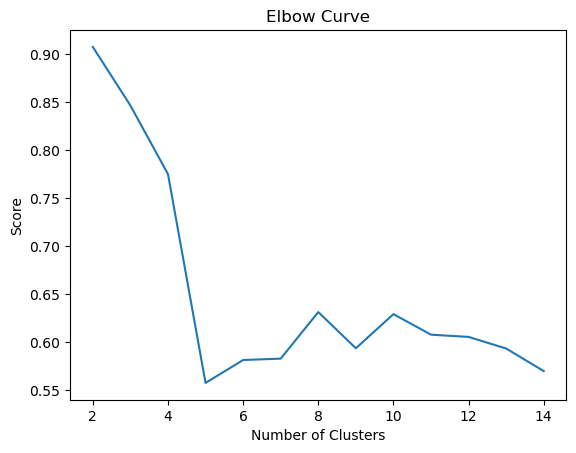

In [68]:
# Calculate cost and plot
import numpy as np
import pandas as pd

n=15
cost = np.zeros(n)

for k in range(2,n):
    kmeans = KMeans(k=k, seed=3)
    model = kmeans.fit(transformed_data)
    #cost[k] = model.computeCost(transformed_data)
    clusterdData = model.transform(transformed_data)
    evaluator = ClusteringEvaluator()
    cost[k] = evaluator.evaluate(clusterdData)

# Plot the cost
df_cost = pd.DataFrame(cost[2:])
df_cost.columns = ["cost"]
new_col = range(2,n)
df_cost.insert(0, 'cluster', new_col)

import pylab as pl
pl.plot(df_cost.cluster, df_cost.cost)
pl.xlabel('Number of Clusters')
pl.ylabel('Score')
pl.title('Elbow Curve')
pl.show()

In [69]:
centers = model.clusterCenters()
print('Cluster Centers: ')
for center in centers:
    print(center)

Cluster Centers: 
[ 0.325      1.625     59.1875    22.2635424  0.225      0.275    ]
[  0.9          1.          44.1        144.56915741   0.8
   0.4       ]
[1.00000000e+00 1.00000000e+00 3.53333333e+01 5.12329224e+02
 3.33333333e-01 1.00000000e+00]
[ 0.26380368  2.84662577 20.36196319  9.35651909  0.3006135   0.25153374]
[  0.71428571   1.          30.64285714 113.08035115   0.5
   0.71428571]
[ 0.5890411   2.63013699  6.33219178 25.57773846  0.52054795  0.26027397]
[  0.73333333   1.          30.33333333 239.99193726   0.73333333
   0.53333333]
[ 0.16666667  2.61666667 43.75        9.51215338  0.2         0.11666667]
[ 0.59459459  1.64864865 26.45945946 51.52151077  0.40540541  0.21621622]
[ 0.59259259  1.03703704 53.40740741 66.65911456  0.44444444  0.51851852]
[  0.5          1.          17.15333334 151.1166687    0.66666667
   0.16666667]
[ 0.28358209  2.69402985 30.25373134 10.36722319  0.24626866  0.19402985]
[ 0.44565217  1.91304348 34.89673913 27.49492606  0.42391304  0.195

**This is our notebook's final cell!**